# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model
* Define Ratings with homogeneous group

# 1. Parameters

In [1]:
#Copiar o caminho path_model_mojo do step "5. Exporting the best model to Deploy" no código "2_Fast_Machine_Learning.ipynb"
path_model_mojo = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/fiep-gpu/code/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_03_hr_analytics_keras/output_model/models/best/StackedEnsemble_BestOfFamily_3_AutoML_3_20221215_21156.zip'

#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [4]:
import sys
sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')

import datetime as dt
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns

# 3. Importing Scored Data for Explain Modeling

In [12]:
dataprep_df_full = pd.read_csv('./HR_Analytics/dataprep_df.csv')

In [13]:
#Importar MOJO
submission_df_tmp = h2o.mojo_predict_pandas(dataprep_df_full, path_model_mojo)    
datascored_df = dataprep_df_full.merge(submission_df_tmp, left_index=True, right_index=True)
datascored_df

Detected 4 unused columns in the input data set: {,employee_id,reference_date,dataset}


,department,region,education,gender,recruitment_channel,kpis_met_80,no_of_trainings,previous_year_rating,age,length_of_service,avg_training_score,employee_id,reference_date,is_promoted,dataset,predict,p0,p1
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,1.0,5.0,35.0,8.0,49.0,65438,2022-03,0,train,0,0.662101,0.337899
1,Operations,region_22,Bachelor's,m,other,0,1.0,5.0,30.0,4.0,60.0,65141,2022-02,0,train,0,0.993164,0.006836
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,0,1.0,3.0,34.0,7.0,50.0,7513,2022-05,0,train,0,0.999698,0.000302
3,Sales & Marketing,region_23,Bachelor's,m,other,0,2.0,1.0,39.0,10.0,50.0,2542,2022-02,0,train,0,0.999941,0.000059
4,Technology,region_26,Bachelor's,m,other,0,1.0,3.0,45.0,2.0,73.0,48945,2022-08,0,test,0,0.998299,0.001701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53564,Technology,region_14,Bachelor's,m,sourcing,0,1.0,3.0,48.0,17.0,78.0,3030,2022-01,0,train,0,0.996509,0.003491
53565,Operations,region_27,Master's & above,f,other,0,1.0,2.0,37.0,6.0,56.0,74592,2022-05,0,train,0,0.999604,0.000396
53566,Analytics,region_1,Bachelor's,m,other,1,1.0,5.0,27.0,3.0,79.0,13918,2022-08,0,test,0,0.894197,0.105803
53567,Sales & Marketing,region_9,Missing,m,sourcing,0,1.0,1.0,29.0,2.0,45.0,13614,2022-07,0,train,0,0.999934,0.000066


In [14]:
#Numeric features must be float type
for col_name in NUM:
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

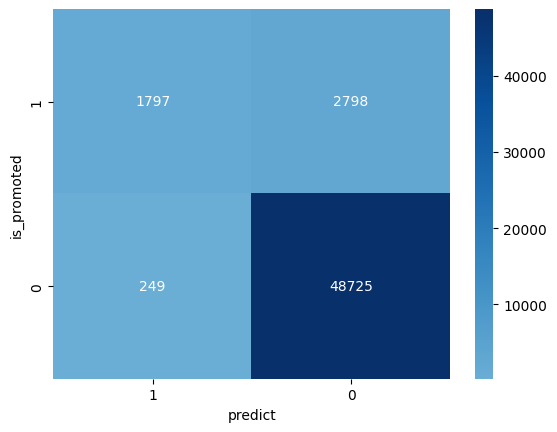

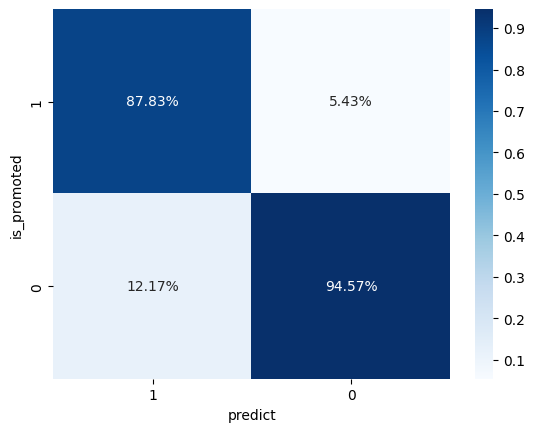

In [15]:
#Confusion Matrix for the Champion
df_matrix = datascored_df.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

In [16]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False).loc[:,('predict','p1')]        
        return self.predictions['p1'].astype('float64').values

In [17]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = datascored_df.loc[:,(selected_features)].sample(n=50, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [18]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

  0%|          | 0/50 [00:00<?, ?it/s]

## 4.1 Main SHAP Graphics

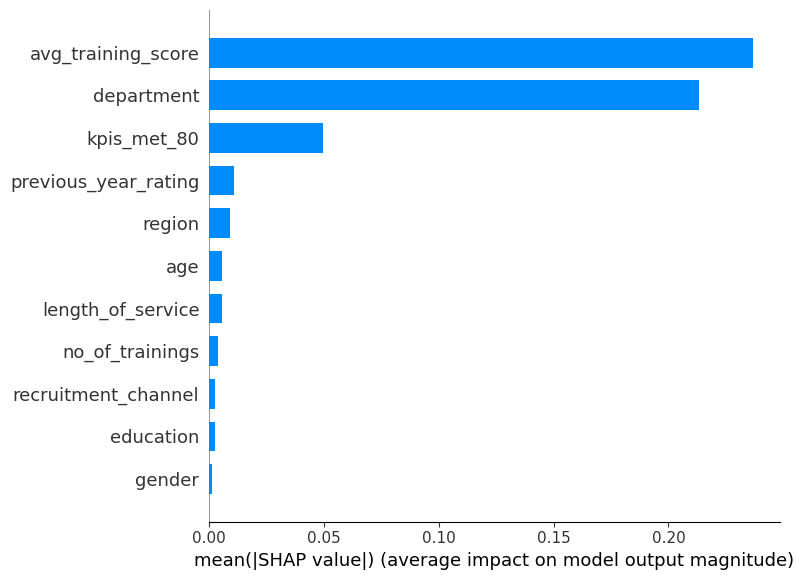

None

In [19]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

None

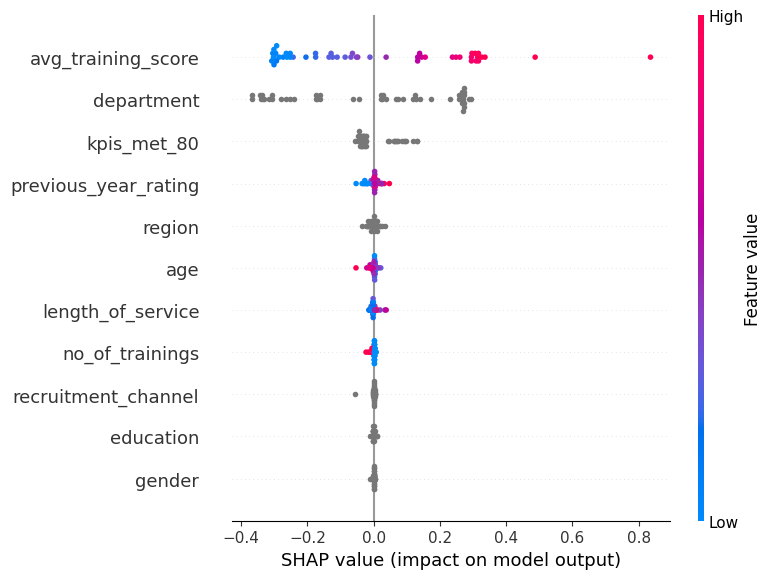

In [20]:
display(shap.summary_plot(h2o_shap_values, shap_sample, show=False))

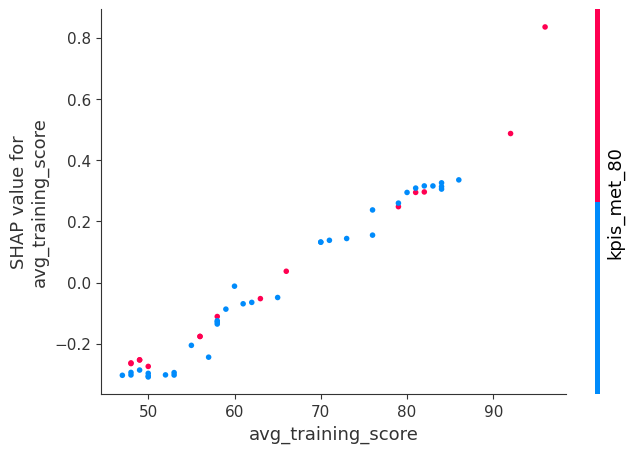

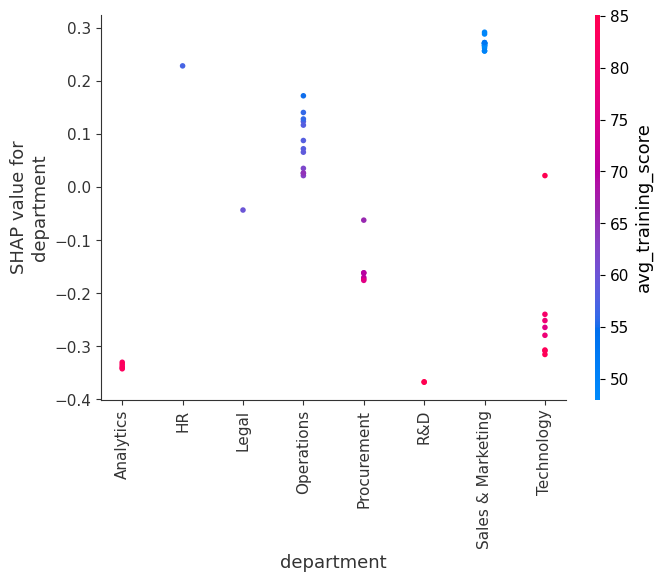

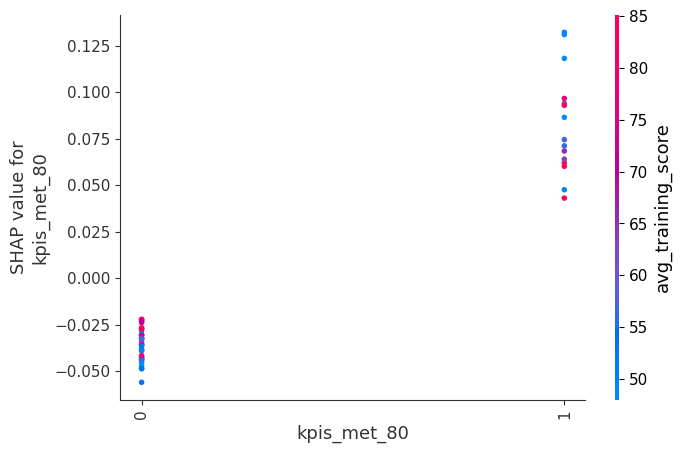

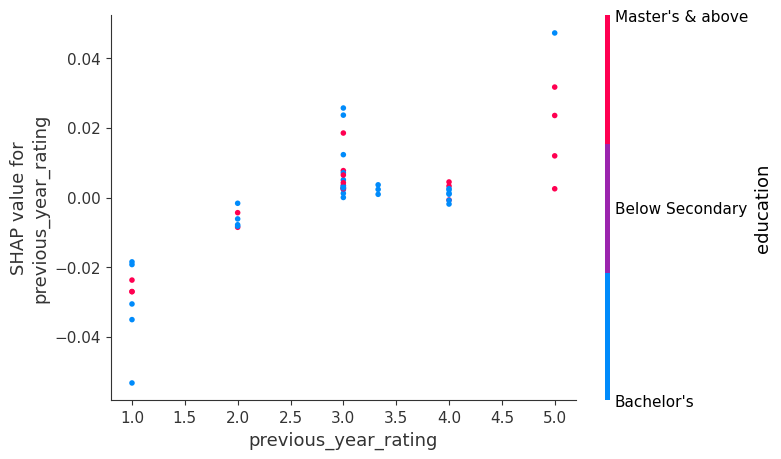

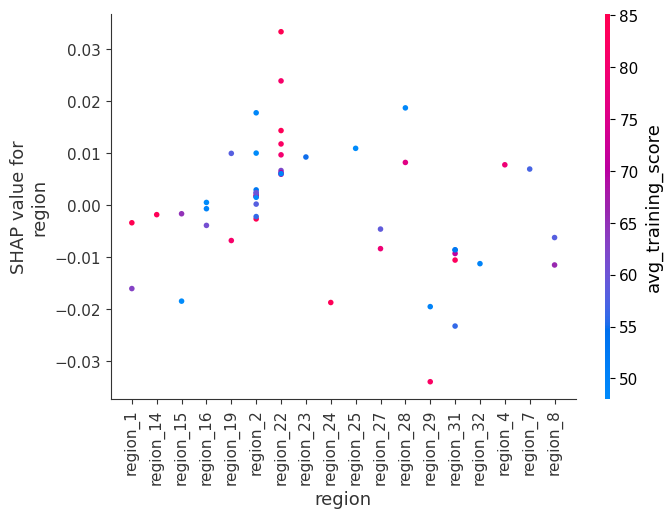

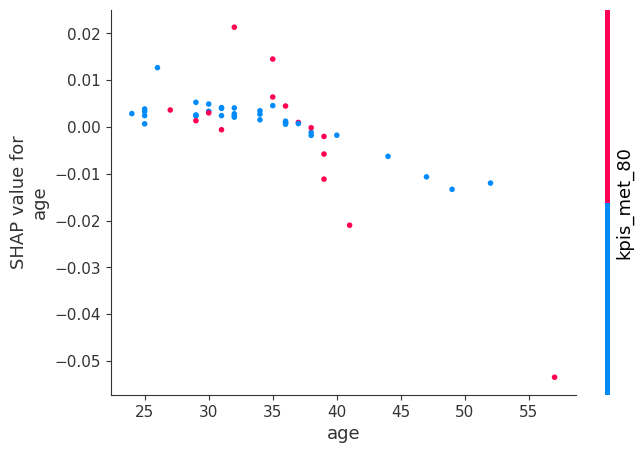

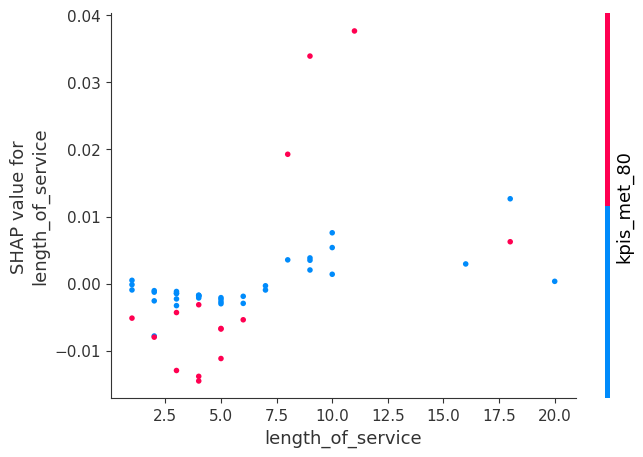

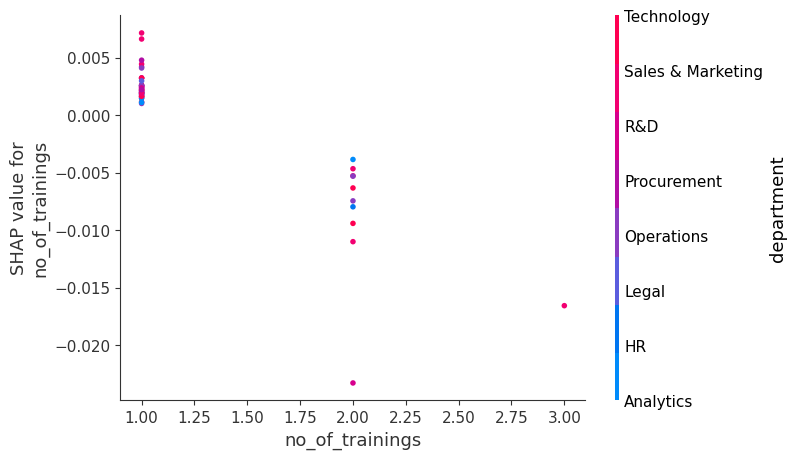

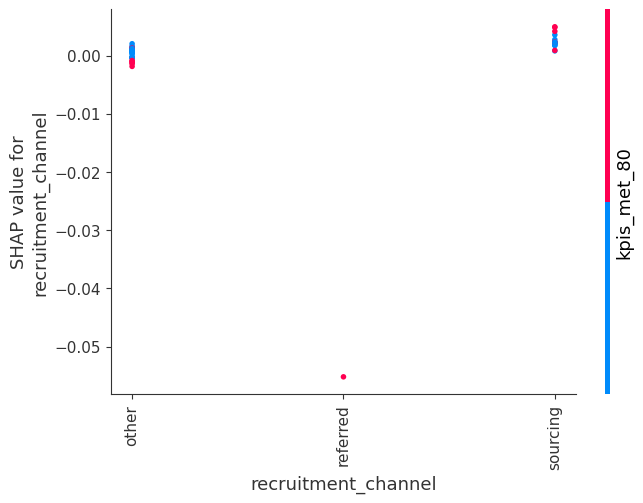

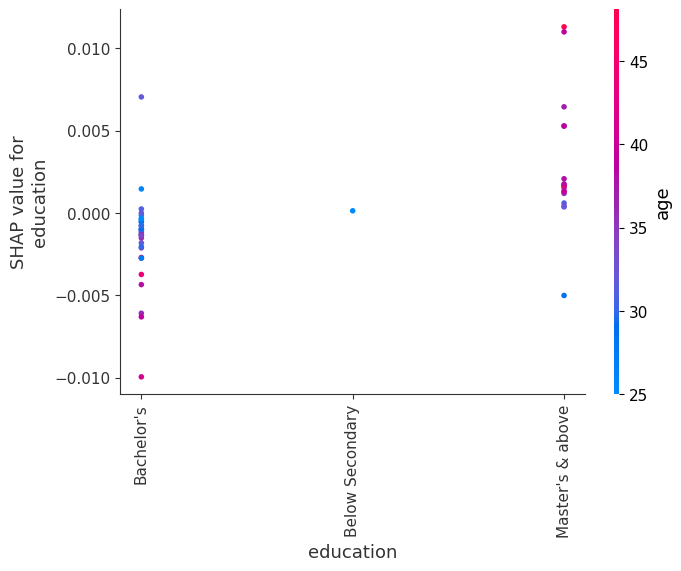

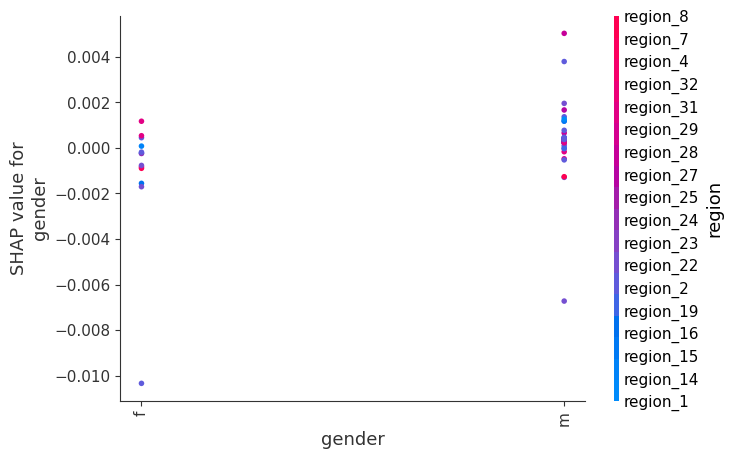

In [21]:
#sort the features indexes by their importance in the model
#(sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(h2o_shap_values),0))

#make SHAP plots of the three most important features
for i in range(len(selected_features)):
    fig=shap.dependence_plot(top_inds[i], h2o_shap_values, shap_sample, show=False)
#     display(fig)

## 4.2 Shap Force Plot

In [22]:
df_shap_values = pd.DataFrame(h2o_shap_values)
df_shap_values['sum_shap'] = df_shap_values.sum(axis=1)

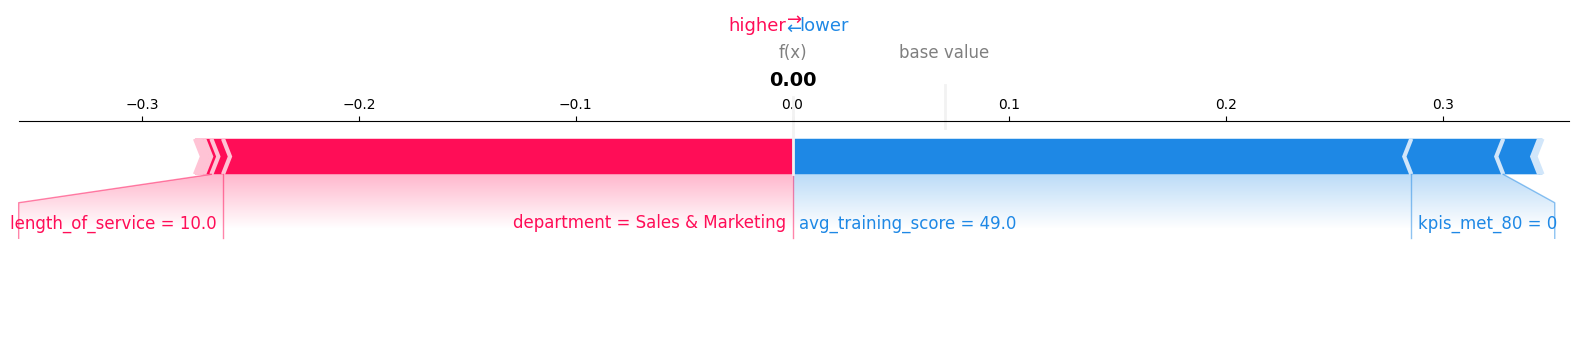

None

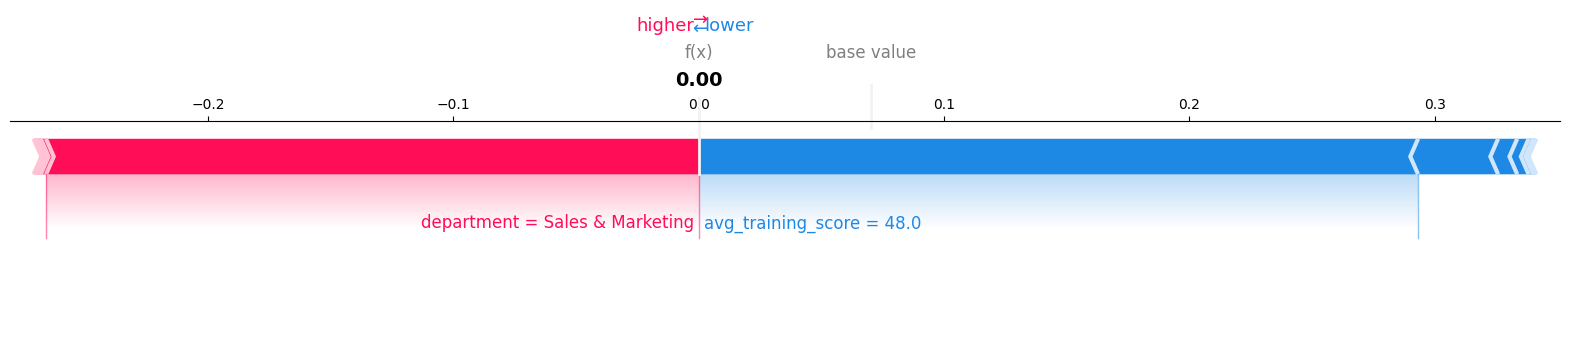

None

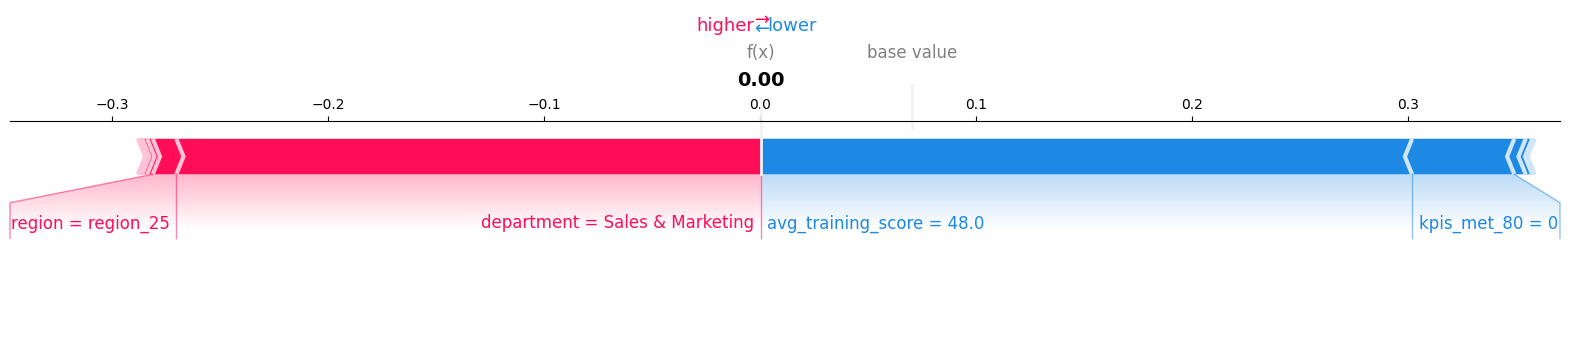

None

In [23]:
for i in df_shap_values.sort_values(by='sum_shap').iloc[0:3,:].index.values:
    fig = shap.force_plot(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:], matplotlib=True, show=True)
    display(fig)